# CNN

In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [2]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CNN.module.lib.layers import *
from Faraday.two_dim.module.lib.layers import *
tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [13]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.sqrt(x_train.astype("float32") / 255.0)
x_test = np.sqrt(x_test.astype("float32") / 255.0)

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [14]:
def create_model(shape):
    inputs = tf.keras.Input((28,28))
    x = ImageResizing(shape)(inputs)
    x = layers.Flatten()(x)
    x = Real2Complex()(x)
    x = ComplexDense(10)(x)
    x = MulConjugate()(x)
    x = Real()(x)
    x = tf.keras.layers.Softmax()(x)

    return tf.keras.Model(inputs, x)

In [59]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/20221124_shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      x = np.arange(n)
      return np.exp(-a*(epoch-1)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [31]:
index = [1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_9 (ImageResi  (None, 28, 28)           0         
 zing)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 real2_complex_8 (Real2Compl  (None, 784)              0         
 ex)                                                             
                                                                 
 complex_dense_8 (ComplexDen  (None, 10)               15680     
 se)                                                             
                                                           

## 追加(14,14)

In [61]:
seeds = [1,2,3,4,5]

for seed in seeds:
    train(0.5, seed)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_35 (ImageRes  (None, 14, 14)           0         
 izing)                                                          
                                                                 
 flatten_34 (Flatten)        (None, 196)               0         
                                                                 
 real2_complex_33 (Real2Comp  (None, 196)              0         
 lex)                                                            
                                                                 
 complex_dense_33 (ComplexDe  (None, 10)               3920      
 nse)                                                            
                                                          

In [4]:
import glob
import re

In [5]:
cmap = plt.get_cmap("tab10")
cmap.colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

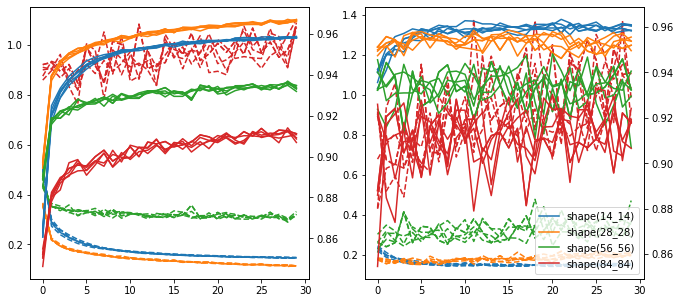

In [19]:
files = glob.glob("/notebooks/trained_model/20221124/*/*.csv")
files.sort()

color_dict = {}
cmap = plt.get_cmap("tab10")

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes_twin = [ax.twinx() for ax in axes]

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)

    axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")


plt.legend()

# ラーニングレート調整

In [18]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/lr_schedule/shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.1
      end = 0.00001
      n = epochs
      b = -1/(n-1) * np.log(end/start)
      a = start * np.exp(b)
      return a*np.exp(-b*(epoch+1))
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, lr_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [19]:
index = [0.5, 1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_20 (ImageRes  (None, 14, 14)           0         
 izing)                                                          
                                                                 
 flatten_20 (Flatten)        (None, 196)               0         
                                                                 
 real2_complex_20 (Real2Comp  (None, 196)              0         
 lex)                                                            
                                                                 
 complex_dense_20 (ComplexDe  (None, 10)               3920      
 nse)                                                            
                                                          

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


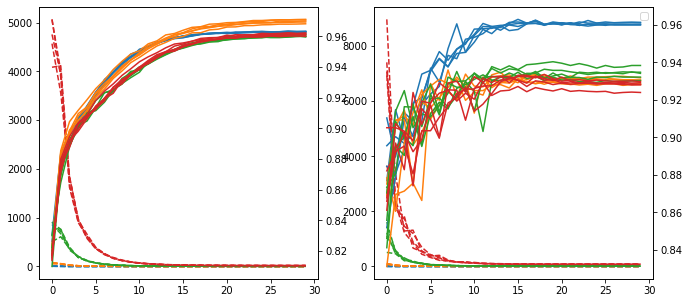

In [22]:
import glob
import re

cmap = plt.get_cmap("tab10")
cmap.colors[0]
files = glob.glob("/notebooks/trained_model/20221124/lr_schedule/*/*.csv")
files.sort()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes_twin = [ax.twinx() for ax in axes]

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)

    axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

plt.legend()

# オプティマイザー
## RMSprop

In [15]:
def train(i, seed):
    shape = (int(28*i), int(28*i))
    tf.random.set_seed(seed)
    model_name = "20221124/optimizer/RMSprop_shape({:d}_{:d})_seed_{:d}_".format(*shape, seed)
    path = "/notebooks/"
    checkpoint_path = path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = path + "trained_model/"+ model_name

    model = create_model(shape)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # category: sparse_categorical_crossentropy
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False), "accuracy"]
                  )

    epochs = 30
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.00001
      n = epochs
      b = -1/(n-1) * np.log(end/start)
      a = start * np.exp(b)
      return a*np.exp(-b*(epoch+1))
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [16]:
index = [0.5, 1, 2, 3]
seeds = [1,2,3,4,5]

for i in index:
    for seed in seeds:
        train(i, seed)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing (ImageResizi  (None, 14, 14)           0         
 ng)                                                             
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                                 
 real2_complex (Real2Complex  (None, 196)              0         
 )                                                               
                                                                 
 complex_dense (ComplexDense  (None, 10)               3920      
 )                                                               
                                                             

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


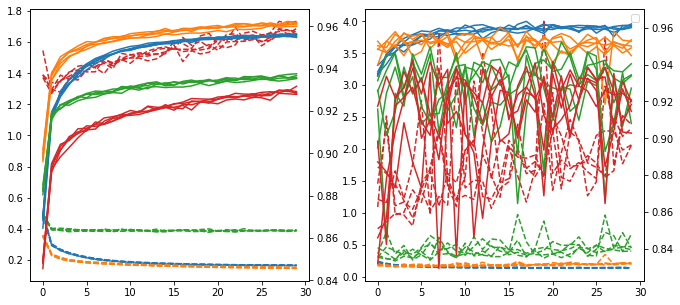

In [23]:
import glob
import re

cmap = plt.get_cmap("tab10")
cmap.colors[0]
files = glob.glob("/notebooks/trained_model/20221124/optimizer/*/*.csv")
files.sort()

fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes_twin = [ax.twinx() for ax in axes]

for f in files:
    df = pd.read_csv(f)
    shape_group = re.search("shape\(.*\)", f).group()
    if shape_group not in color_dict:
        color_dict[shape_group] = cmap.colors[len(color_dict)]
        axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)
        axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--", label=shape_group)
        axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-", label=shape_group)

    axes[0].plot(df["loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[0].plot(df["accuracy"], color=color_dict[shape_group], linestyle="-")
    axes[1].plot(df["val_loss"], color=color_dict[shape_group], linestyle="--")
    axes_twin[1].plot(df["val_accuracy"], color=color_dict[shape_group], linestyle="-")

plt.legend()

# 結論
大体96%で打ち止め